# Titanic Survival Prediction - Random Forest Pipeline with Hyperparameter Tuning

## 1. Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.inspection import permutation_importance

## 2. Load and Preprocess Data

In [11]:
def load_data():
    return pd.read_csv('data/train.csv')

df = load_data()
df.drop(columns=["Cabin", "Ticket", "PassengerId"], inplace=True)

X = df.drop('Survived', axis=1)
y = df['Survived']


## 3. Feature Engineering Transformers

In [12]:
class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        X['Title'] = X['Title'].replace(['Lady', 'Countess','Capt', 'Col', 
                                         'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                         'Jonkheer', 'Dona'], 'Rare')
        X['Title'] = X['Title'].replace(['Mlle', 'Ms'], 'Miss')
        X['Title'] = X['Title'].replace('Mme', 'Mrs')
        return X

In [13]:
class FamilyFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
        X['Solo'] = X['IsAlone'] * X['Fare']
        X['femClass'] = X['Sex'].map({'male': 0, 'female': 1}) * X['Pclass']
        return X

## 4. Define Column Types

In [14]:
# ====== Define Column Types ======
num_features = ['Age', 'Fare', 'FamilySize', 'Solo', 'femClass']
cat_features = ['Sex', 'Embarked', 'Title', 'IsAlone']

##  5. Preprocessing Pipelines

In [15]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

## 6. Full Pipeline

In [16]:
base_pipeline = Pipeline([
    ('title', TitleExtractor()),
    ('family', FamilyFeatures()),
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

##  7. GridSearchCV

In [17]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 5],
    'clf__max_features': ['sqrt'],
    'clf__class_weight': ['balanced']
}

grid_search = GridSearchCV(base_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

print("\nBest Parameters:", grid_search.best_params_)
print("\nBest CV Accuracy:", grid_search.best_score_)



Best Parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 100}

Best CV Accuracy: 0.8293892411022534


## 8. Final Evaluation

In [18]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.84444444 0.80898876 0.80898876 0.86516854 0.80898876 0.86516854
 0.85393258 0.80898876 0.85393258 0.85393258]
Mean accuracy: 0.8372534332084894


##  9. Feature Importances

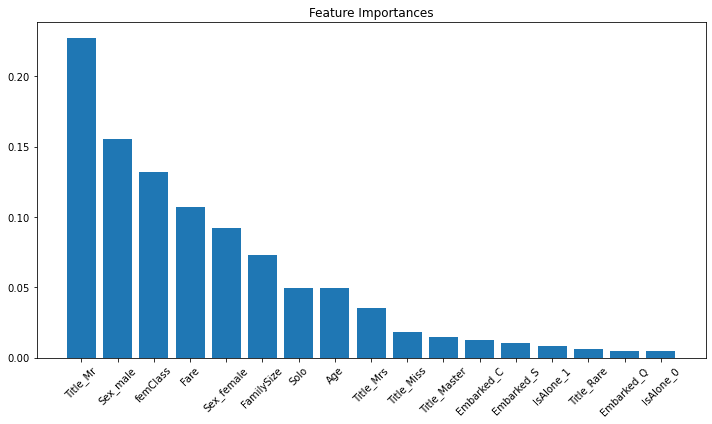

In [21]:
final_model = grid_search.best_estimator_
final_model.fit(X, y)

feature_names = list(final_model.named_steps['preprocessor'].transformers_[0][2]) + \
                list(final_model.named_steps['preprocessor'].transformers_[1][1] \
                     .named_steps['onehot'].get_feature_names(cat_features))

importances = final_model.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

## 10. Permutation Importance

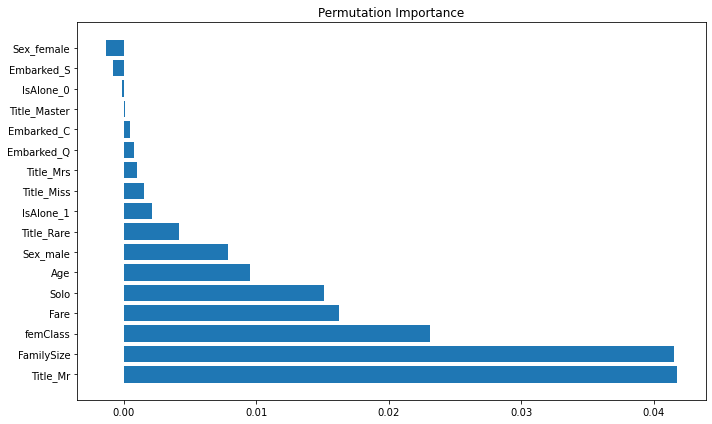

In [22]:
X_transformed = final_model[:-1].transform(X)
result = permutation_importance(final_model.named_steps['clf'], X_transformed, y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()